In [3]:
import tqdm
from preprocessing import exctract_json_data, define_categories
import numpy as np
import os
import cv2


data_directory = "/Users/mjo/Desktop/WLASL/Processed_data/100"


count_dictionary, video_id_dictionary = exctract_json_data()
labels_100, _, _, _, _ = define_categories(count_dictionary)

labels_iterated = {}
counter = 0
for label in labels_100:
    labels_iterated[label] = counter
    counter += 1

inv_video_id_dictionary = {}
for k, v in video_id_dictionary.items(): 
    for video in v:
        inv_video_id_dictionary[video] = k
        
def make_training_data(labels_x, video_id_dictionary, labels_iterated):
    training_data = []
    num_labels = len(labels_x)
    for label in (labels_x):
        for video in video_id_dictionary[label]:
            path = os.path.join(data_directory, video)
            for file in (os.listdir(path)):
                if "jpg" in file:
                    try:
                        path = os.path.join(data_directory,video, file)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        training_data.append((np.array(img), np.eye(num_labels)[labels_iterated[label]]))
                    except Exception as e:
                        print(e)
                        pass
    return training_data

training_data = make_training_data(labels_100, video_id_dictionary, labels_iterated)

In [4]:
path = '/Users/mjo/Desktop/WLASL/Processed_data/100/frame46.jpg'
img = cv2.imread(path)
print(img)

None


In [5]:
print(np.eye(len(labels_100))[labels_iterated['book']])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [6]:
import torch
trainloader = torch.utils.data.DataLoader(training_data, batch_size=20,
                                          shuffle=True, num_workers=2)

(256, 256)


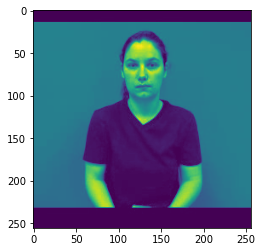

In [7]:
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(training_data[800][0].shape)
plt.imshow(training_data[5][0])
plt.show()

In [65]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 256, 5)
        self.conv3 = nn.Conv2d(256, 512, 5)
        self.conv4 = nn.Conv2d(512, 256, 5)
        self.fc3 = nn.Linear(16384, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x.double())))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = x.view(20, -1)
        x = self.fc3(x)
        return F.softmax(x, dim=1)


net = Net().double()

In [66]:
print(net)

Net(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(512, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc3): Linear(in_features=16384, out_features=100, bias=True)
)


In [67]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.view(-1,1,256,256)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

tensor(0.0102, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0103, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0102, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0102, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0103, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0102, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0098, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0102, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0102, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0102, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0102, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0102, dtype=torch.float64, grad_fn=<MseLossBac